In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'  
from pprint import pprint

In [3]:
import numpy as np
X_train=np.random.uniform(-1,1,(200,2))
Y_train=np.logical_xor(X_train[:,0]>0,X_train[:,1]>0).astype(int)
X_test=np.random.uniform(-1,1,(200,2))
Y_test=np.logical_xor(X_test[:,0]>0,X_test[:,1]>0).astype(int)


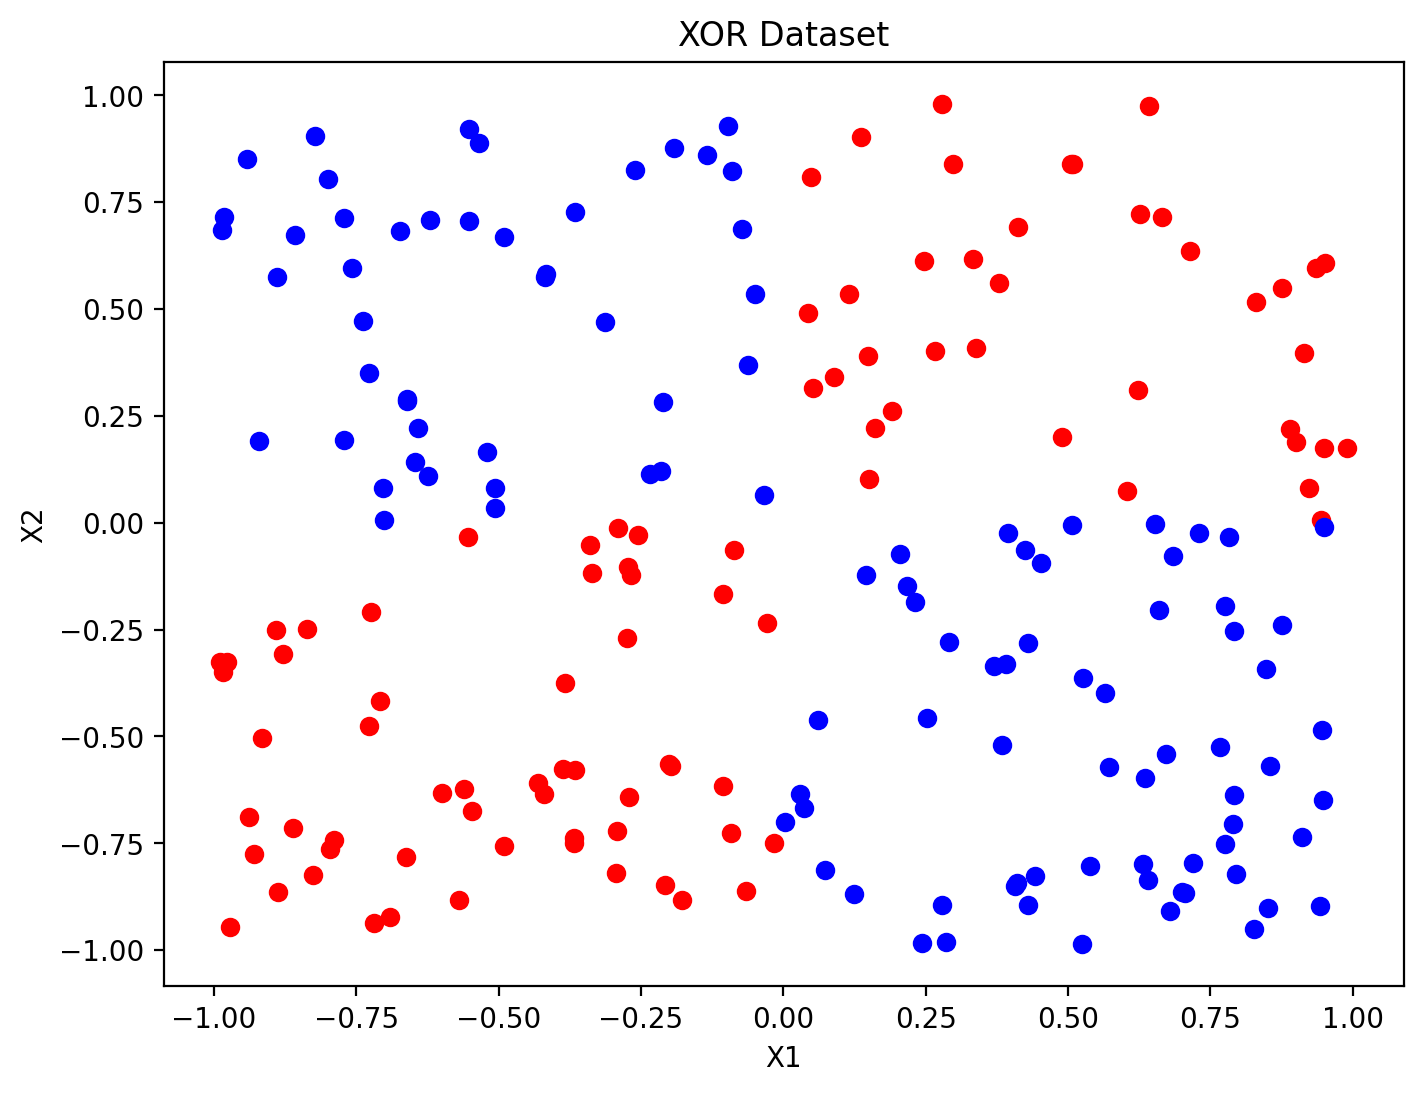

In [4]:
plt.figure(figsize=(8, 6))
for i in range(len(Y_train)):
    if Y_train[i] == 1:
        plt.scatter(X_train[i, 0], X_train[i, 1], c='blue')
    else:
        plt.scatter(X_train[i, 0], X_train[i, 1], c='red')

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("XOR Dataset")
plt.show()

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1) 

X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.hidden=nn.Linear(2,10)
        self.output=nn.Linear(10,1)
    def forward(self,x):
        x=torch.relu(self.hidden(x))
        x=torch.sigmoid(self.output(x))
        return x
model=MLP()

In [7]:
criterion = nn.BCELoss() 
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
output=model(X_train_t)
output.shape


torch.Size([200, 1])

In [9]:
Y_train_t.shape

torch.Size([200, 1])

In [10]:
epochs=500
for i in range(1,epochs+1):
    model.train()
    output=model(X_train_t)
    loss=criterion(output,Y_train_t)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i%10==0:
        print("Epochs",i,"Loss: ", loss)

Epochs 10 Loss:  tensor(0.6680, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 20 Loss:  tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 30 Loss:  tensor(0.5922, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 40 Loss:  tensor(0.5320, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 50 Loss:  tensor(0.4635, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 60 Loss:  tensor(0.3971, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 70 Loss:  tensor(0.3404, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 80 Loss:  tensor(0.2956, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 90 Loss:  tensor(0.2609, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 100 Loss:  tensor(0.2337, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 110 Loss:  tensor(0.2121, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 120 Loss:  tensor(0.1946, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 130 Loss:  tensor(0.1800, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 140 Loss:  tensor(0.1676, grad_fn=<BinaryCrossEntropyBackward0>)
E

Test Accuracy: 99.50%


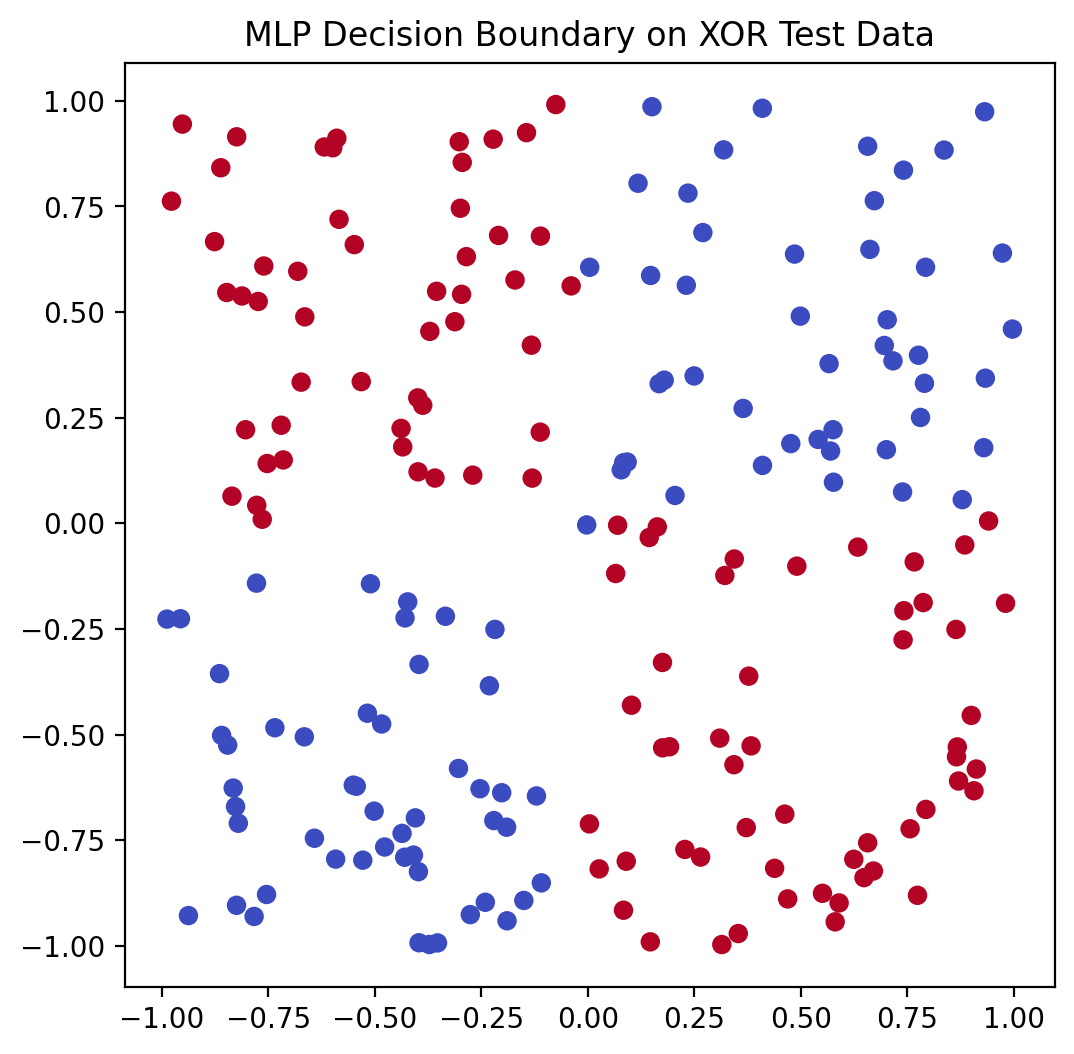

In [11]:
model.eval()
with torch.no_grad():
    output=model(X_test_t)
    pred=output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(6, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred.squeeze(), cmap='coolwarm')
plt.title('MLP Decision Boundary on XOR Test Data')
plt.show()


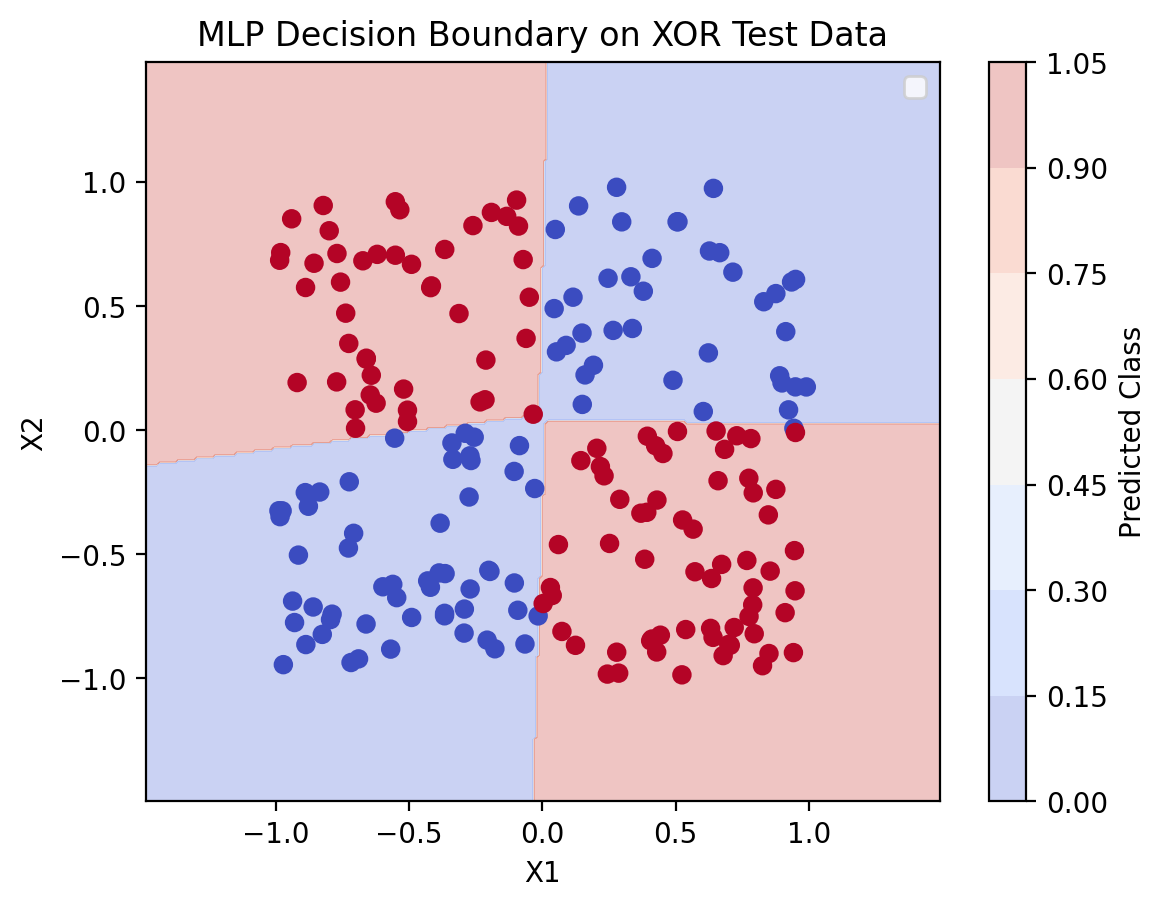

In [12]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()

# **MLP w/ L1 regularization**

In [13]:
def l1_reg(model, lamda):
    l1_norm=sum(p.abs().sum() for p in model.parameters())
    return lamda*l1_norm

X_val_t = X_train_t[160:]
Y_val_t = Y_train_t[160:]
X_train_t = X_train_t[:160]
Y_train_t = Y_train_t[:160]


In [14]:
lambda_l1=0.001
model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
for epoch in range(1, epochs + 1):
    model.train()
    output = model(X_train_t)
    loss = criterion(output, Y_train_t) + l1_reg(model, lambda_l1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.6738
Epoch 20, Loss: 0.6525
Epoch 30, Loss: 0.6267
Epoch 40, Loss: 0.5933
Epoch 50, Loss: 0.5504
Epoch 60, Loss: 0.5062
Epoch 70, Loss: 0.4675
Epoch 80, Loss: 0.4340
Epoch 90, Loss: 0.4048
Epoch 100, Loss: 0.3783
Epoch 110, Loss: 0.3526
Epoch 120, Loss: 0.3259
Epoch 130, Loss: 0.3002
Epoch 140, Loss: 0.2756
Epoch 150, Loss: 0.2527
Epoch 160, Loss: 0.2335
Epoch 170, Loss: 0.2175
Epoch 180, Loss: 0.2044
Epoch 190, Loss: 0.1935
Epoch 200, Loss: 0.1843
Epoch 210, Loss: 0.1766
Epoch 220, Loss: 0.1699
Epoch 230, Loss: 0.1641
Epoch 240, Loss: 0.1590
Epoch 250, Loss: 0.1544
Epoch 260, Loss: 0.1503
Epoch 270, Loss: 0.1466
Epoch 280, Loss: 0.1433
Epoch 290, Loss: 0.1403
Epoch 300, Loss: 0.1375
Epoch 310, Loss: 0.1350
Epoch 320, Loss: 0.1327
Epoch 330, Loss: 0.1306
Epoch 340, Loss: 0.1287
Epoch 350, Loss: 0.1269
Epoch 360, Loss: 0.1253
Epoch 370, Loss: 0.1237
Epoch 380, Loss: 0.1223
Epoch 390, Loss: 0.1210
Epoch 400, Loss: 0.1197
Epoch 410, Loss: 0.1186
Epoch 420, Loss: 0.1175
E

In [15]:
model.eval()
with torch.no_grad():
    output = model(X_test_t)
    pred = output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 97.50%


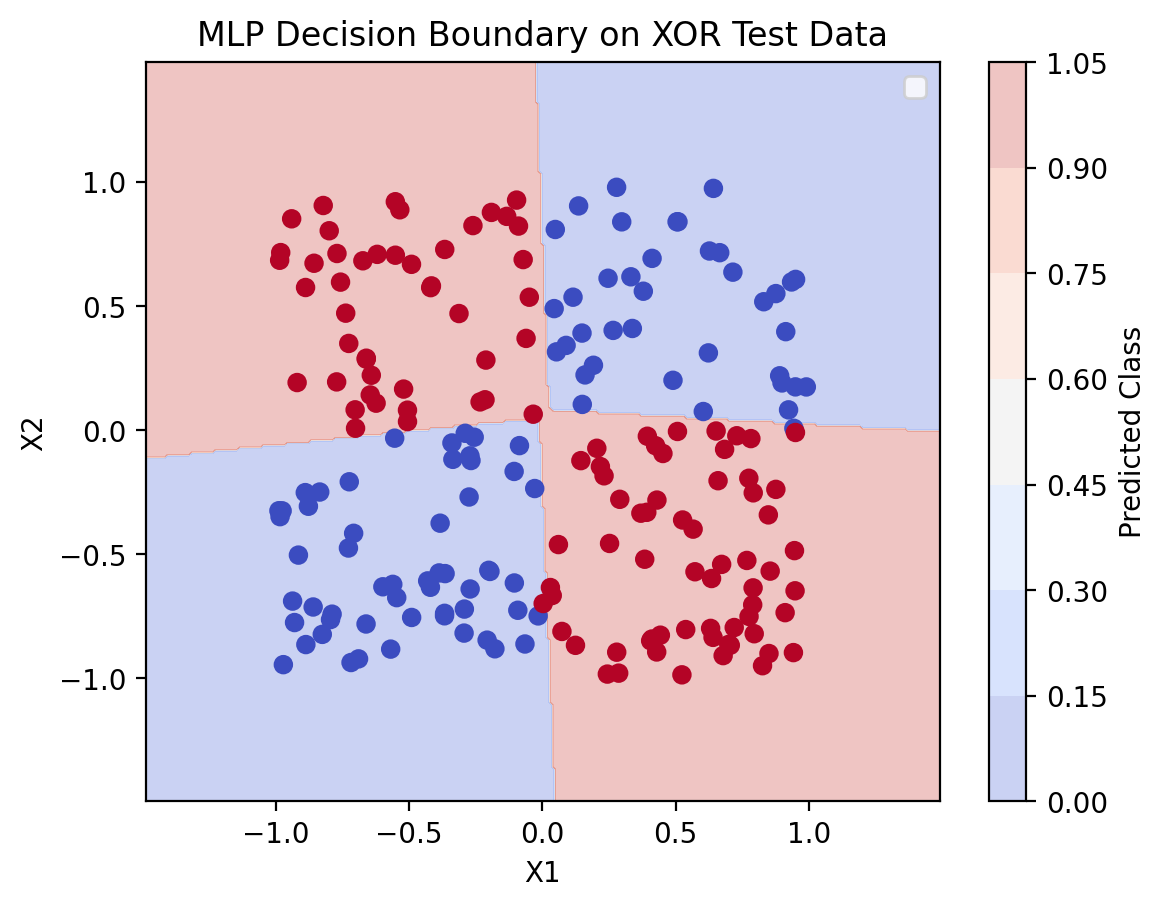

In [16]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()

In [17]:
l1_values = [ 0.01, 0.1]
model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for lambda_l1 in l1_values:
    # Initialize and train the model as before
    model = MLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(X_train_t)
        loss = criterion(output, Y_train_t) + l1_reg(model, lambda_l1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate model after training
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_t)
        val_pred = val_output.round()
        val_accuracy = (val_pred.eq(Y_val_t).sum() / float(Y_val_t.shape[0])).item()
        print(f'L1 Lambda: {lambda_l1}, Validation Accuracy: {val_accuracy * 100:.2f}%')

L1 Lambda: 0.01, Validation Accuracy: 90.00%
L1 Lambda: 0.1, Validation Accuracy: 32.50%


# **MLP w/ L2**

In [18]:
lambda_l2 = 0.001  # L2 regularization parameter
model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)

In [19]:
epochs = 500
for epoch in range(1, epochs + 1):
    model.train()
    output = model(X_train_t)
    loss = criterion(output, Y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.6808
Epoch 20, Loss: 0.6563
Epoch 30, Loss: 0.6247
Epoch 40, Loss: 0.5826
Epoch 50, Loss: 0.5354
Epoch 60, Loss: 0.4896
Epoch 70, Loss: 0.4473
Epoch 80, Loss: 0.4101
Epoch 90, Loss: 0.3790
Epoch 100, Loss: 0.3535
Epoch 110, Loss: 0.3329
Epoch 120, Loss: 0.3160
Epoch 130, Loss: 0.3015
Epoch 140, Loss: 0.2888
Epoch 150, Loss: 0.2768
Epoch 160, Loss: 0.2656
Epoch 170, Loss: 0.2553
Epoch 180, Loss: 0.2460
Epoch 190, Loss: 0.2374
Epoch 200, Loss: 0.2294
Epoch 210, Loss: 0.2221
Epoch 220, Loss: 0.2152
Epoch 230, Loss: 0.2087
Epoch 240, Loss: 0.2026
Epoch 250, Loss: 0.1969
Epoch 260, Loss: 0.1917
Epoch 270, Loss: 0.1868
Epoch 280, Loss: 0.1822
Epoch 290, Loss: 0.1780
Epoch 300, Loss: 0.1740
Epoch 310, Loss: 0.1701
Epoch 320, Loss: 0.1664
Epoch 330, Loss: 0.1629
Epoch 340, Loss: 0.1596
Epoch 350, Loss: 0.1565
Epoch 360, Loss: 0.1535
Epoch 370, Loss: 0.1506
Epoch 380, Loss: 0.1478
Epoch 390, Loss: 0.1452
Epoch 400, Loss: 0.1427
Epoch 410, Loss: 0.1403
Epoch 420, Loss: 0.1380
E

In [20]:
model.eval()
with torch.no_grad():
    output = model(X_test_t)
    pred = output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 94.00%


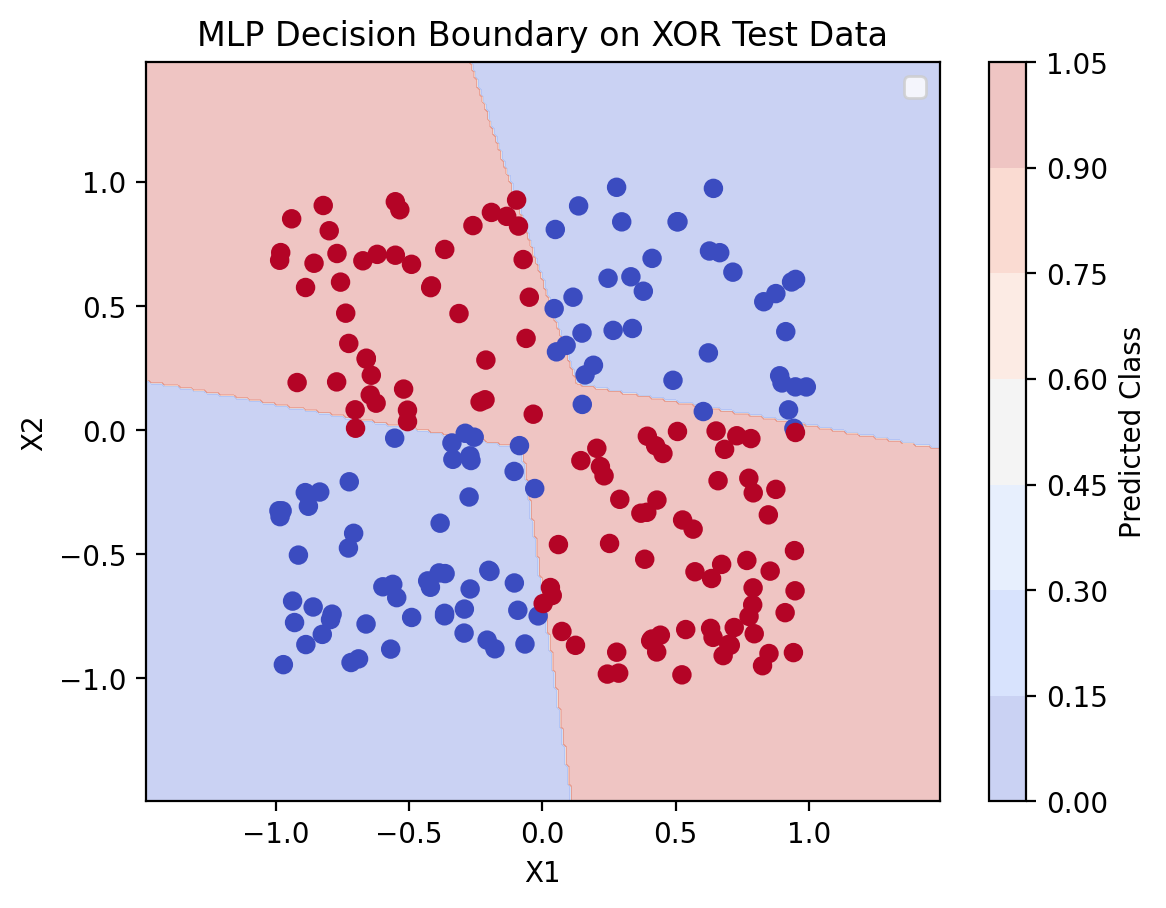

In [21]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()

In [22]:
l2_values = [0.001, 0.01, 0.1]
for lambda_l2 in l2_values:
    # Initialize and train the model as before
    model = MLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(X_train_t)
        loss = criterion(output, Y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate model after training
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_t)
        val_pred = val_output.round()
        val_accuracy = (val_pred.eq(Y_val_t).sum() / float(Y_val_t.shape[0])).item()
        print(f'L2 Lambda: {lambda_l2}, Validation Accuracy: {val_accuracy * 100:.2f}%')

L2 Lambda: 0.001, Validation Accuracy: 97.50%
L2 Lambda: 0.01, Validation Accuracy: 95.00%
L2 Lambda: 0.1, Validation Accuracy: 32.50%


# additional Feature

In [23]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [24]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [25]:
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(Y_train).unsqueeze(1)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(Y_test).unsqueeze(1)

In [26]:
X_train_poly_torch = torch.FloatTensor(X_train_poly)
X_test_poly_torch = torch.FloatTensor(X_test_poly)

In [27]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [28]:
input_dim = X_train_poly.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [29]:
epochs = 500
for epoch in range(1,epochs+1):
    # Forward pass
    outputs = model(X_train_poly_torch)
    loss = criterion(outputs, y_train_torch)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch}], Loss: {loss.item():.4f}')

Epoch [100], Loss: 0.5304
Epoch [200], Loss: 0.4638
Epoch [300], Loss: 0.4207
Epoch [400], Loss: 0.3901
Epoch [500], Loss: 0.3670


In [30]:
with torch.no_grad():
    y_pred_train = model(X_train_poly_torch).round()
    y_pred_test = model(X_test_poly_torch).round()
    
    train_accuracy = (y_pred_train.eq(y_train_torch).sum() / float(y_train_torch.shape[0])).item() * 100
    test_accuracy = (y_pred_test.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item() * 100

print(f'Train Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')


Train Accuracy: 92.00%
Test Accuracy: 93.50%


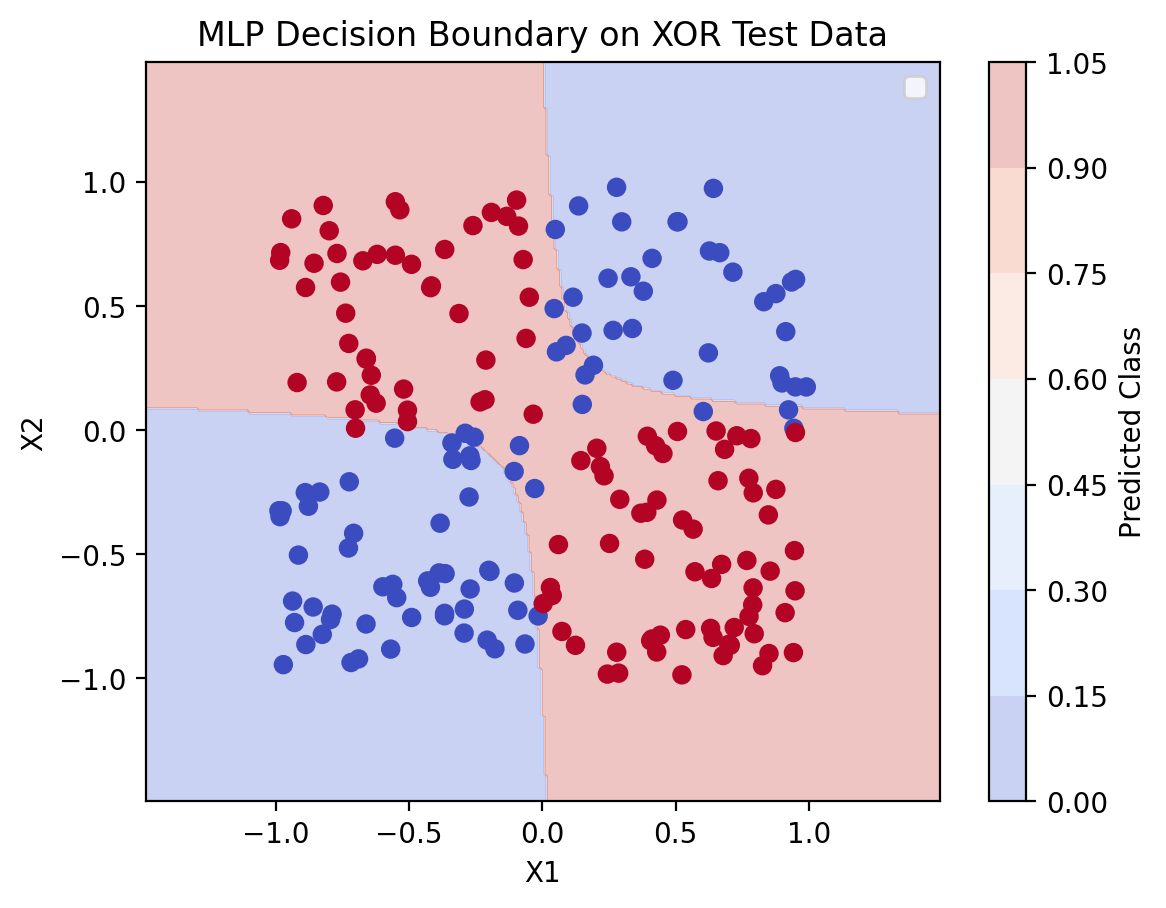

In [34]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_poly = poly.transform(grid_data)  # Transform grid data to match polynomial features
grid_data_t = torch.tensor(grid_data_poly, dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()